In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
source("../../hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
source("../../hires_gastrulation/CHARMtools/Rlibs/hires_utils.R")
library(ggpubr)
library(plotly)
library(Matrix)
library(ComplexHeatmap)
library(GetoptLong)
library(circlize)
library(gghighlight)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘plotl

In [356]:
hires <- readRDS("../hires_mouse_emb_dev.new.rds")

In [ ]:
# 读取TSV文件并处理矩阵数据
# 
# 该代码块完成以下操作：
# 1. 从指定路径读取TSV格式的数据文件
# 2. 提取特定列范围的数据（第45到138列）
# 3. 将列顺序进行反转
# 4. 设置行名为细胞名称

mat <- read_tsv("../cdps.tsv")

# 提取第45到138列的数据，保留特定的特征列
mat <- mat[,45:138]

# 将数据框的列名顺序反转
mat <- mat[,rev(names(mat))]

# 从hires对象中提取cellname列作为矩阵的行名
rownames(mat) <- hires[[]] %>% pull(cellname)

Rows: 7469 Columns: 151
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (151): 0.0, 1000.0, 1090.5077326652577, 1189.2071150027211, 1296.8395546...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [358]:
colors <-c("#f7fbff","#deebf7","#c6dbef","#9ecae1","#6baed6","#4292c6","#2171b5","#084594")

## generateplot for all cell types and also generate pileup code

In [ ]:
# 定义细胞周期各阶段的颜色映射表，用于可视化中区分不同的细胞周期阶段
# 颜色按照从紫色到绿色再到橙色的渐变，体现细胞周期的生物学顺序
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")#,"Unknown"="#f5f5f5")

# 定义通用蓝色渐变色板，包含从浅蓝到深蓝的8个颜色层次
# 适用于需要展示数据强度或等级的可视化场景
colors <-c("#f7fbff","#deebf7","#c6dbef","#9ecae1","#6baed6","#4292c6","#2171b5","#084594")

In [361]:
library(ComplexHeatmap)

In [ ]:
# 初始化一个空列表，用于存储每个细胞类型的元数据
metadatas <- list()

# 遍历所有细胞类型，按细胞数量从高到低排序
for (celltype_i in hires[[]] %>% group_by(celltype) %>% summarise(count = n()) %>% arrange(desc(count)) %>% pull(celltype)){

    # 设置随机种子以保证结果可重复
    set.seed(42)

    # 筛选当前细胞类型的数据，并对部分列进行标准化处理
    tempOrderDF <- hires[[]] %>% 
        select(cellname, pre_meta_score, order_index, near_p, mitotic_p, farAvg, NaganoCellcycle, stage, repli_score, celltype, G1S.Score, G2M.Score, Phase, CC.Score) %>%
        mutate(
            G1S.Score = scale(G1S.Score),
            G2M.Score = scale(G2M.Score),
            repli_score = scale(repli_score)
        ) %>% 
        filter(celltype == celltype_i) 

    # 提取当前细胞类型的所有细胞名称
    temp_cell_names <- tempOrderDF %>% pull(cellname)

    # 构建热图矩阵：选取对应细胞的基因表达数据并转置
    heatmap_mat <- mat[temp_cell_names, ] %>% t() %>% as.data.frame
    names(heatmap_mat) <- temp_cell_names

    # 对热图数据进行K-means聚类（分为12类）
    kmeans_res <- as.data.frame(kmeans(t(heatmap_mat), 12)$cluster) %>% rownames_to_column("cellname")
    names(kmeans_res) <- c("cellname", "cluster")

    # 将聚类结果合并回原始数据框
    tempOrderDF <- tempOrderDF %>% left_join(kmeans_res)

    # 对每个主聚类进一步进行子聚类分析
    tempOrderDF_by_clusters <- list()
    for (cluster_i in tempOrderDF %>% pull(cluster) %>% unique()) {
        tempOrderDF_by_cluster <- tempOrderDF %>% filter(cluster == cluster_i)

        # 如果该簇中细胞数小于等于3，则不进行子聚类，直接编号
        if(dim(tempOrderDF_by_cluster)[1] <= 3) {
            tempOrderDF_by_cluster <- tempOrderDF_by_cluster %>% mutate(sub_k_cluster = paste0("sub_c", row_number()))
        } else {
            # 否则对G1S、G2M和复制时间分数进行标准化后再次K-means聚类（分为3类）
            tempOrderDF_by_cluster <- cbind(
                tempOrderDF_by_cluster,
                as.data.frame(paste0("sub_c", (tempOrderDF_by_cluster %>% select(G1S.Score, G2M.Score, repli_score) %>% scale() %>% kmeans(3))$cluster))
            )
            names(tempOrderDF_by_cluster)[16] <- "sub_k_cluster"
        }

        # 将处理后的子聚类数据加入列表
        tempOrderDF_by_clusters <- c(tempOrderDF_by_clusters, list(tempOrderDF_by_cluster))
    }

    # 合并所有子聚类结果
    tempOrderDF <- bind_rows(tempOrderDF_by_clusters)

    # 打乱顺序后按照主聚类和子聚类重新排序
    tempOrderDF <- tempOrderDF[sample(1:nrow(tempOrderDF)), ] %>% arrange(cluster, sub_k_cluster)

    # 根据排序后的细胞顺序重新排列热图矩阵
    heatmap_mat <- heatmap_mat[, tempOrderDF %>% pull(cellname)] %>% as.data.frame

    # 定义颜色映射函数用于可视化
    col_fun = colorRamp2(c(-1, 0, 1), c("#ffffff", "#9c76c2", "#272d74"))
    col_fun1 = colorRamp2(c(-1, 0, 1), c("#ffffff", "#7eb5b4", "#058786"))

    # 创建热图顶部注释对象
    topAnno <- HeatmapAnnotation(
        df = tempOrderDF %>% column_to_rownames("cellname") %>% select(sub_k_cluster, repli_score, G1S.Score, G2M.Score),
        col = list(
            sub_k_cluster = c("sub_c1" = "#fc8d59", "sub_c2" = "#ffffbf", "sub_c3" = "#91bfdb"),
            repli_score = col_fun,
            G1S.Score = col_fun1,
            G2M.Score = col_fun1
        )
    )

    # 生成pileup命令脚本，用于后续Hi-C数据处理
    tempOrderDF %>% 
        select(cellname, celltype, cluster) %>% 
        mutate(command = paste0(
            "zcat ../../HiC/pairs/", cellname, ".pairs.gz| grep -v '#' >> ../cellcycle_alltypes/",
            str_replace_all(celltype_i, " ", "_"), "_clsuter", cluster, ".pairs"
        )) %>% 
        select(command) %>% 
        write_tsv(paste0("pileup_command/pileup_", celltype_i, ".sh"), col_names = FALSE)

    # 设置绘图参数
    options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)

    # 绘制热图
    p <- Heatmap(
        heatmap_mat %>% as.matrix(),
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        col = colors,
        show_row_names = FALSE,
        show_column_names = FALSE,
        top_annotation = topAnno,
        column_split = tempOrderDF %>% select(cluster),
        use_raster = FALSE,
        heatmap_legend_param = list(title = "contacts %"),
        border = TRUE
    )

    # 保存热图为SVG格式
    svg(qq(paste0("cellcycle_alltypes/cdps_heatmaps/", celltype_i, ".svg")), width = 12, height = 6)
    draw(p)
    dev.off()

    # 将当前细胞类型的元数据添加到总列表中
    metadatas <- c(metadatas, list(tempOrderDF))
}

Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "cellname"


In [ ]:
# 合并多个元数据对象并处理子聚类标签
# 将多个元数据对象按行合并，提取子聚类标签中的数字部分并转换为数值型
metadata <- bind_rows(metadatas) %>% mutate(sub_k_cluster = as.numeric(str_extract(sub_k_cluster,"[0-9]")))

# 读取细胞周期注释文件
# 从CSV文件中读取细胞周期相关的注释信息
cellcycle_anno <- read_csv("cellcycle_annotation.csv")

# 整合细胞周期注释信息并整理元数据
# 将细胞周期注释信息与主元数据进行左连接，按细胞名称排序，
# 临时保存细胞名称用于设置行名，最后将细胞名称设置为数据框的行名
metadata <- metadata %>% left_join(cellcycle_anno) %>% arrange(cellname) %>% mutate(temp=cellname) %>%  column_to_rownames("temp")

Rows: 755 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): celltype, cellcycle, cellcycle7
dbl (2): cluster, sub_k_cluster

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("celltype", "cluster", "sub_k_cluster")


`summarise()` has grouped output by 'celltype', 'cluster', 'sub_k_cluster'. You can override using the `.groups` argument.


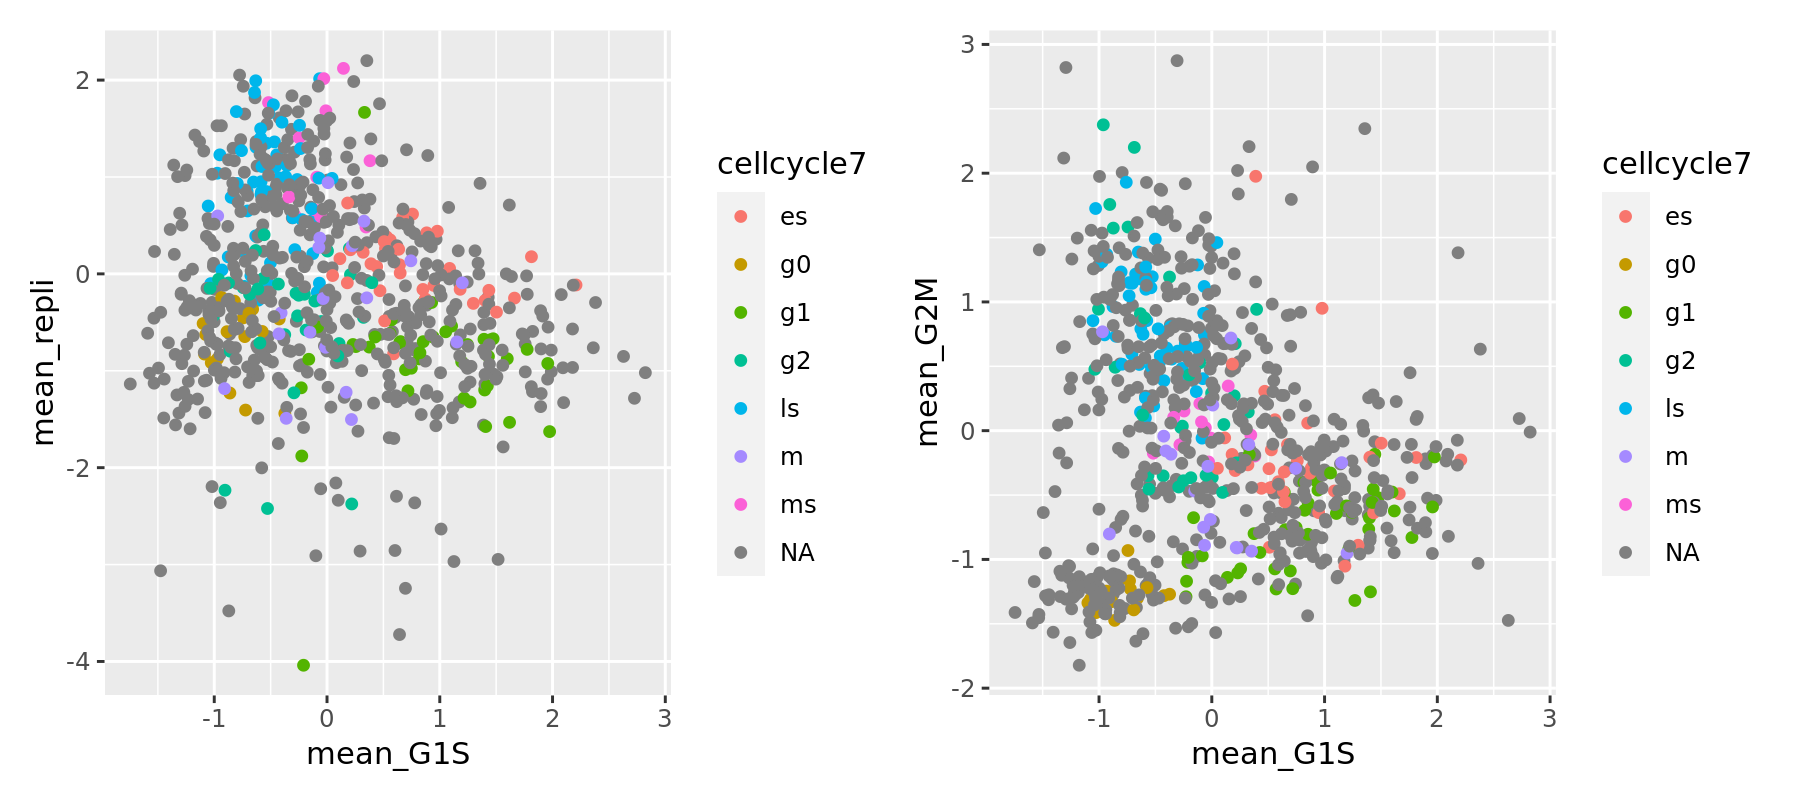

In [15]:
data <- metadata %>% group_by(celltype,cluster,sub_k_cluster,cellcycle7)  %>% summarise(count = n(),mean_G1S = mean(G1S.Score),mean_G2M = mean(G2M.Score),mean_repli = mean(repli_score)) %>%# filter(count > 10)%>% 
    arrange(desc(count)) #%>% filter(count > 10) 
a <- data %>%  ggplot() + geom_point(aes(x=mean_G1S,y=mean_repli,color=cellcycle7)) #+ NoLegend()
b <- data %>% ggplot() + geom_point(aes(x=mean_G1S,y=mean_G2M,color=cellcycle7))
options(repr.plot.width=9,repr.plot.height=4,repr.plot.res=200)
a | b

`summarise()` has grouped output by 'celltype', 'cluster', 'sub_k_cluster'. You can override using the `.groups` argument.


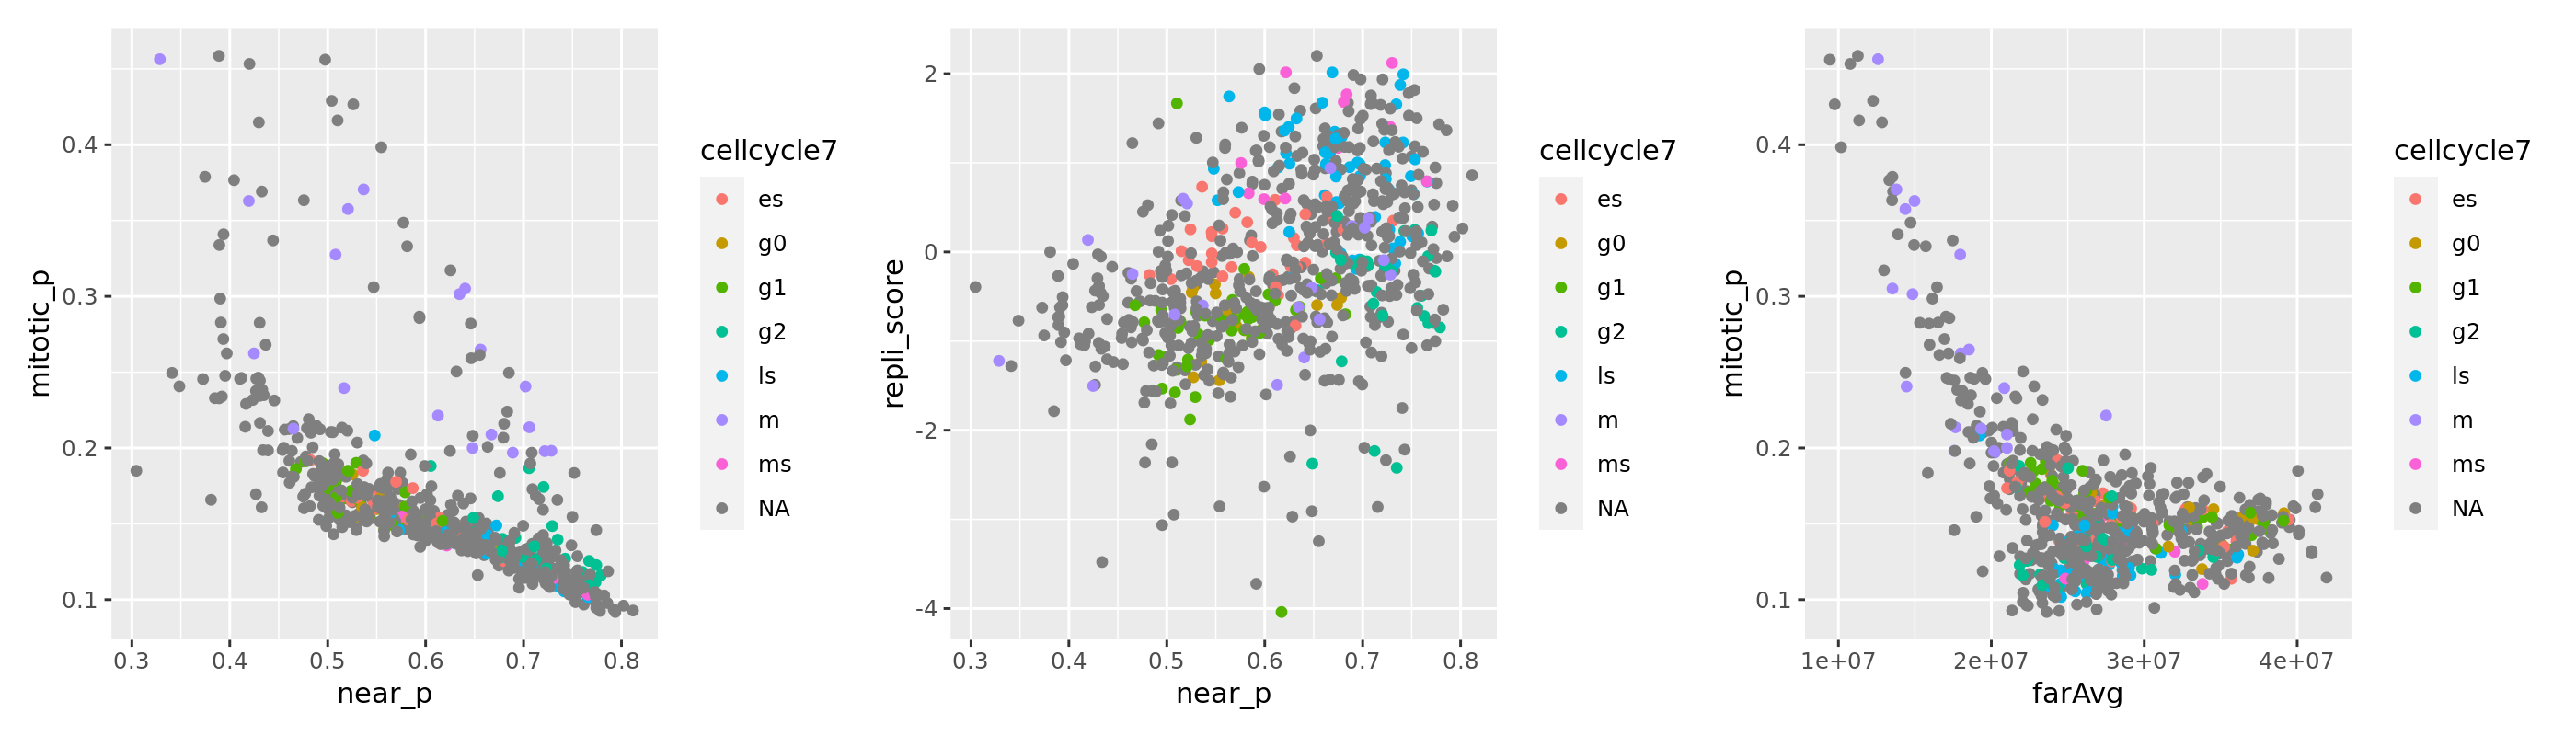

In [12]:
data <- metadata %>% group_by(celltype,cluster,sub_k_cluster,cellcycle7)  %>% summarise(count = n(),near_p = mean(near_p),mitotic_p = mean(mitotic_p),farAvg = mean(farAvg),repli_score=mean(repli_score)) %>% #filter(count > 10)%>% 
    arrange(desc(count)) #%>% filter(count > 10) 
options(repr.plot.width=14,repr.plot.height=4,repr.plot.res=200)
a <- data %>%  ggplot() + geom_point(aes(x=near_p,y=mitotic_p,color=cellcycle7))
b <- data %>% ggplot() + geom_point(aes(x=near_p,y=repli_score,color=cellcycle7))
c <- data %>% ggplot() + geom_point(aes(x=farAvg,y=mitotic_p,color=cellcycle7))
a | b | c

`summarise()` has grouped output by 'celltype', 'cluster', 'sub_k_cluster'. You can override using the `.groups` argument.


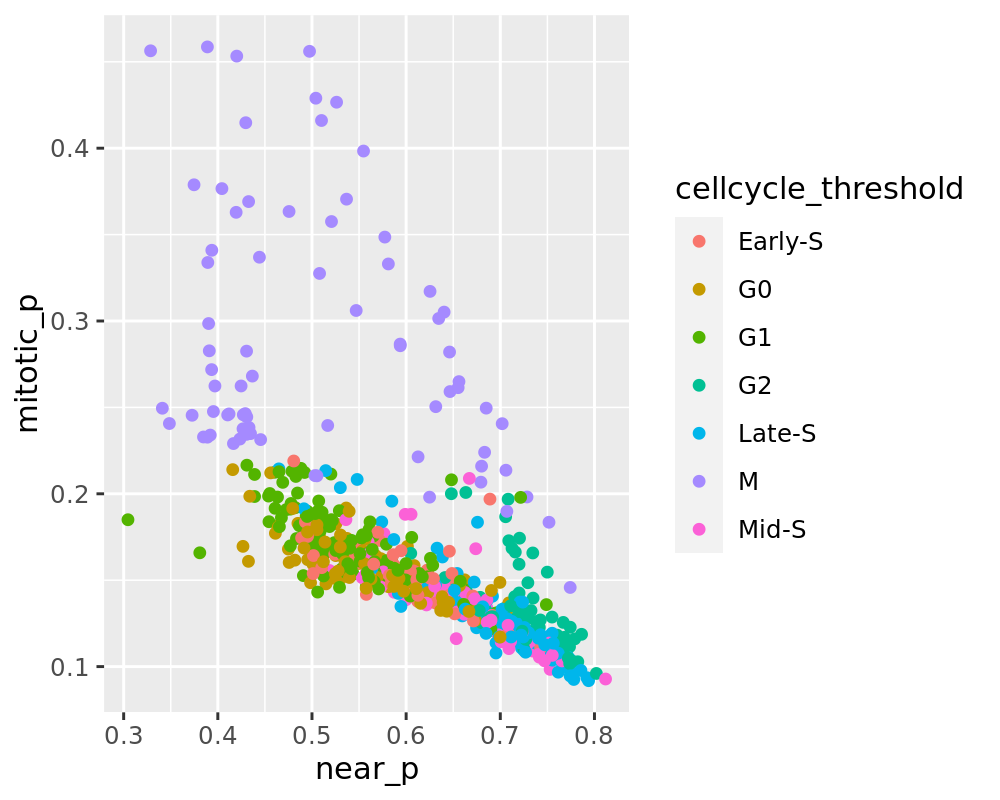

In [157]:
data <- hires[[]] %>% group_by(celltype,cluster,sub_k_cluster,cellcycle_threshold)  %>% summarise(count = n(),near_p = mean(near_p),mitotic_p = mean(mitotic_p)) %>% #filter(count > 10)%>% 
    arrange(desc(count)) #%>% filter(count > 10) 
options(repr.plot.width=5,repr.plot.height=4,repr.plot.res=200)
a <- data %>%  ggplot() + geom_point(aes(x=near_p,y=mitotic_p,color=cellcycle_threshold))
a

In [439]:
# metadata_new <- metadata %>% group_by(celltype,cluster,sub_k_cluster) %>% 
#     mutate(count = n(),mean_G1S = mean(G1S.Score),mean_G2M = mean(G2M.Score),mean_repli = mean(repli_score),mean_near_p = mean(near_p),mean_mitotic_p = mean(mitotic_p),mean_farAvg = mean(farAvg)) %>%
#     mutate(cellcycle_threshold = ifelse(!(mean_mitotic_p < 0.22 & mean_farAvg > (1.9e+07)),"M",
#                                         ifelse(mean_G2M < -0.5 & mean_repli < 0.2 & mean_G1S < -0.25,"G0",
#                                              ifelse(mean_near_p > 0.685 & mean_repli < 0 & mean_G2M < 1,"G2",
#                                                   ifelse(mean_G1S > -0.25 & mean_repli < 0.05 & (mean_G2M < -0.35 | ((mean_G1S > 1/2*mean_G2M + 0.2) & mean_mitotic_p > 0.18))  ,"G1",
#                                                         ifelse(mean_G1S > 1/2*mean_G2M + 0.2,"Early-S",
#                                                               ifelse((mean_G1S < mean_G2M - 1) & mean_repli < 1.35,"Late-S",
#                                                                      #"Mid-S"
#                                                                      ifelse(mean_repli > 0.3,"Mid-S","Unknown")
#                                                                     )))))))

# This version gives slightly bad results than the above, but is simpler. 
metadata %>% mutate(cellcycle_simple = ifelse(!(mean_mitotic_p < 0.22 & mean_farAvg > (1.9e+07)),"M",
                                        ifelse(mean_G2M < -0.5 & mean_repli < 0 & mean_G1S < -0.25,"G0",
                                             ifelse(mean_near_p > 0.7 & mean_repli < 0 ,"G2",
                                                  ifelse(mean_repli < 0 & mean_G1S > -0.25 & mean_G2M < 0,"G1",
                                                         ifelse(mean_G1S > 0.4 & mean_G2M < 0.3,"Early-S",
                                                                ifelse(mean_G2M > 0.8 ,"Late-S",
                                                                         ifelse(mean_repli > 0.5,"Mid-S","Unknown")
                                                                    ))))))) -> metadata_new
#metadata_new <- metadata_new %>% mutate(cellcycle_threshold = ifelse(cellcycle_threshold == "Early-S" & mean_mitotic_p > 0.175,"G1",cellcycle_threshold))
metadata_new <- metadata_new %>% ungroup() %>% mutate(temp=cellname) %>%  column_to_rownames("temp")

In [442]:
hires@meta.data$cellcycle_threshold <- metadata_new$cellcycle_threshold 
unknown_metanew <- read_tsv("unknown_cellcycle.tsv") %>% ungroup() %>% select(celltype,cluster,sub_k_cluster,cellcycle_threshold)
hires@meta.data <- rbind(hires@meta.data %>% filter(cellcycle_threshold == "Unknown") %>% select(-cellcycle_threshold) %>% left_join(unknown_metanew) %>% mutate(temp=cellname) %>% column_to_rownames("temp"),hires@meta.data %>% filter(cellcycle_threshold != "Unknown") )
hires@meta.data$cellcycle_threshold  <- factor(hires@meta.data$cellcycle_threshold ,levels=c("G0","M","G1","Early-S","Mid-S","Late-S","G2","Unknown"))

Rows: 38 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): celltype, cellcycle_threshold
dbl (9): cluster, sub_k_cluster, count, mean_G1S, mean_G2M, mean_repli, mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("celltype", "cluster", "sub_k_cluster")


In [443]:
hires@meta.data <- hires@meta.data %>% arrange(cellname)

In [444]:
hires@meta.data$raw_repli_score <- read_tsv("../metadata_qcpass.tsv")$raw_repli_score # %>% select(cellname,raw_repli_score)

Rows: 7469 Columns: 77
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): cellname, orig.ident, pairs, NaganoCellcycle, stage, celltype, Pha...
dbl (65): maxbinorder, UMAP_1, UMAP_2, nCount_RNA, nFeature_RNA, Rawreads, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


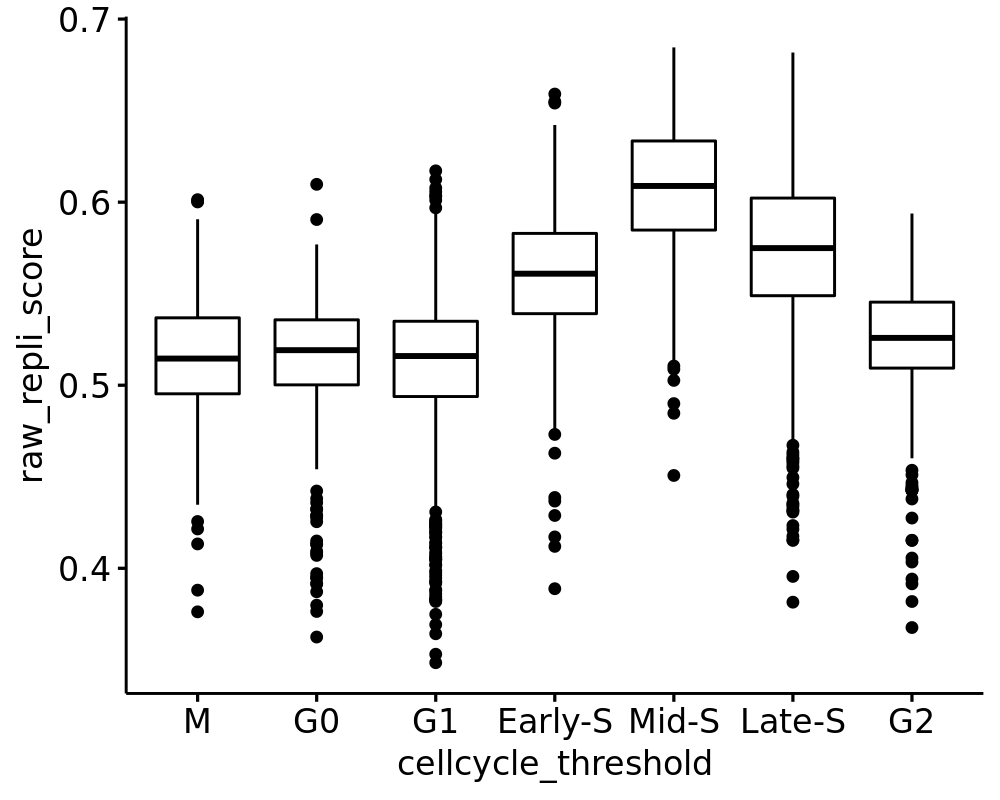

In [455]:
options(repr.plot.width=5,repr.plot.height=4,repr.plot.res=200)
hires@meta.data %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="raw_repli_score")

In [446]:
hires@meta.data %>% group_by(cellcycle_threshold) %>% summarise(n())

cellcycle_threshold,n()
<fct>,<int>
G0,1181
M,446
G1,1606
Early-S,766
Mid-S,1242
Late-S,1853
G2,375


`summarise()` has grouped output by 'celltype', 'cluster', 'sub_k_cluster'. You can override using the `.groups` argument.


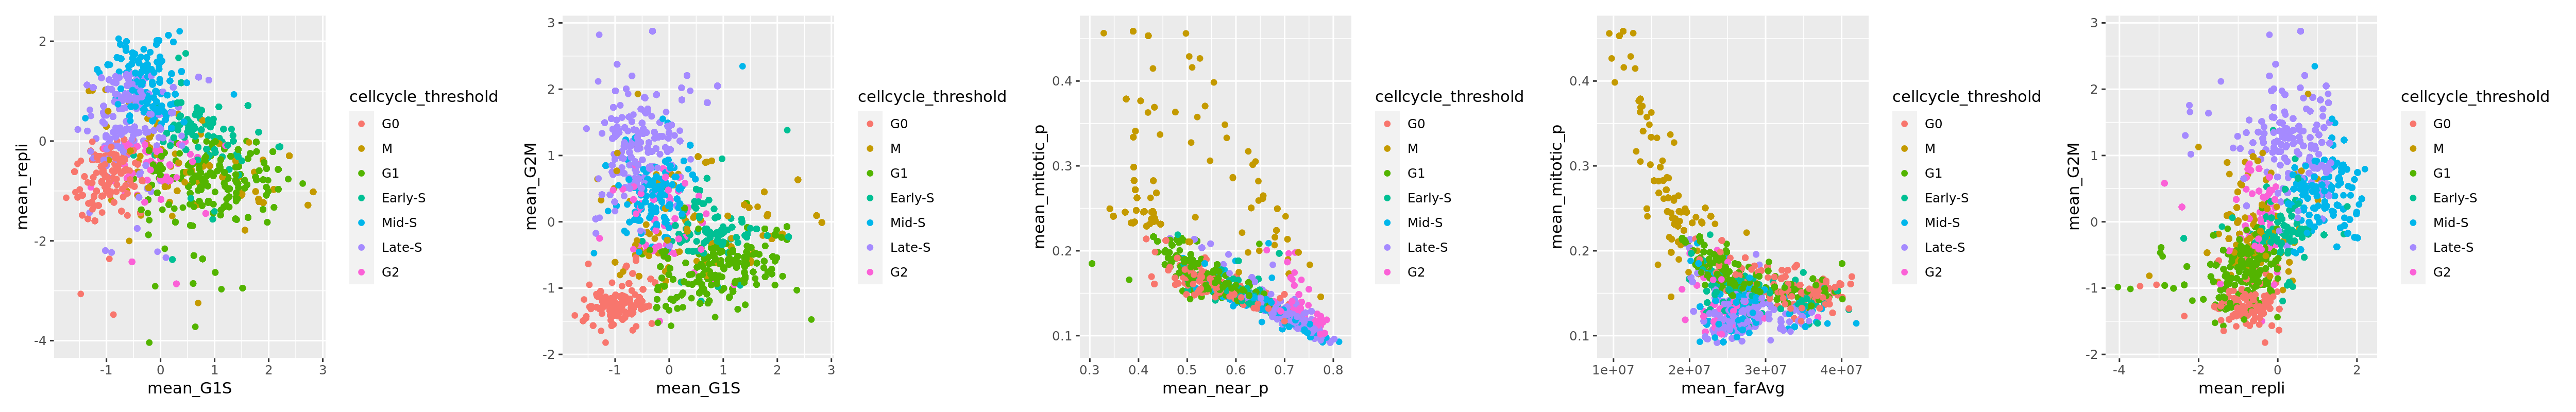

In [447]:
data <- hires[[]] %>%  group_by(celltype,cluster,sub_k_cluster) %>% 
    summarise(count = n(),mean_G1S = mean(G1S.Score),mean_G2M = mean(G2M.Score),mean_repli = mean(repli_score),mean_near_p = mean(near_p),mean_mitotic_p = mean(mitotic_p),mean_farAvg = mean(farAvg),cellcycle_threshold=cellcycle_threshold)

a <- data %>%  ggplot() + geom_point(aes(x=mean_G1S,y=mean_repli,color=cellcycle_threshold)) #+ scale_color_manual(values=cellcyclecolors) + NoLegend()
b <- data %>% ggplot() + geom_point(aes(x=mean_G1S,y=mean_G2M,color=cellcycle_threshold))#+ scale_color_manual(values=cellcyclecolors)
c <- data %>% ggplot() + geom_point(aes(x=mean_near_p,y=mean_mitotic_p,color=cellcycle_threshold))
d <- data %>% ggplot() + geom_point(aes(x=mean_farAvg,y=mean_mitotic_p,color=cellcycle_threshold))
e <- data %>% ggplot() + geom_point(aes(x=mean_repli,y=mean_G2M,color=cellcycle_threshold))
options(repr.plot.width=25,repr.plot.height=4,repr.plot.res=200)
a| b | c | d | e
#(a | b) %>% ggsave(filename = "plots/cellcycle_threshold.svg",width=8,height=4)

png 
  2

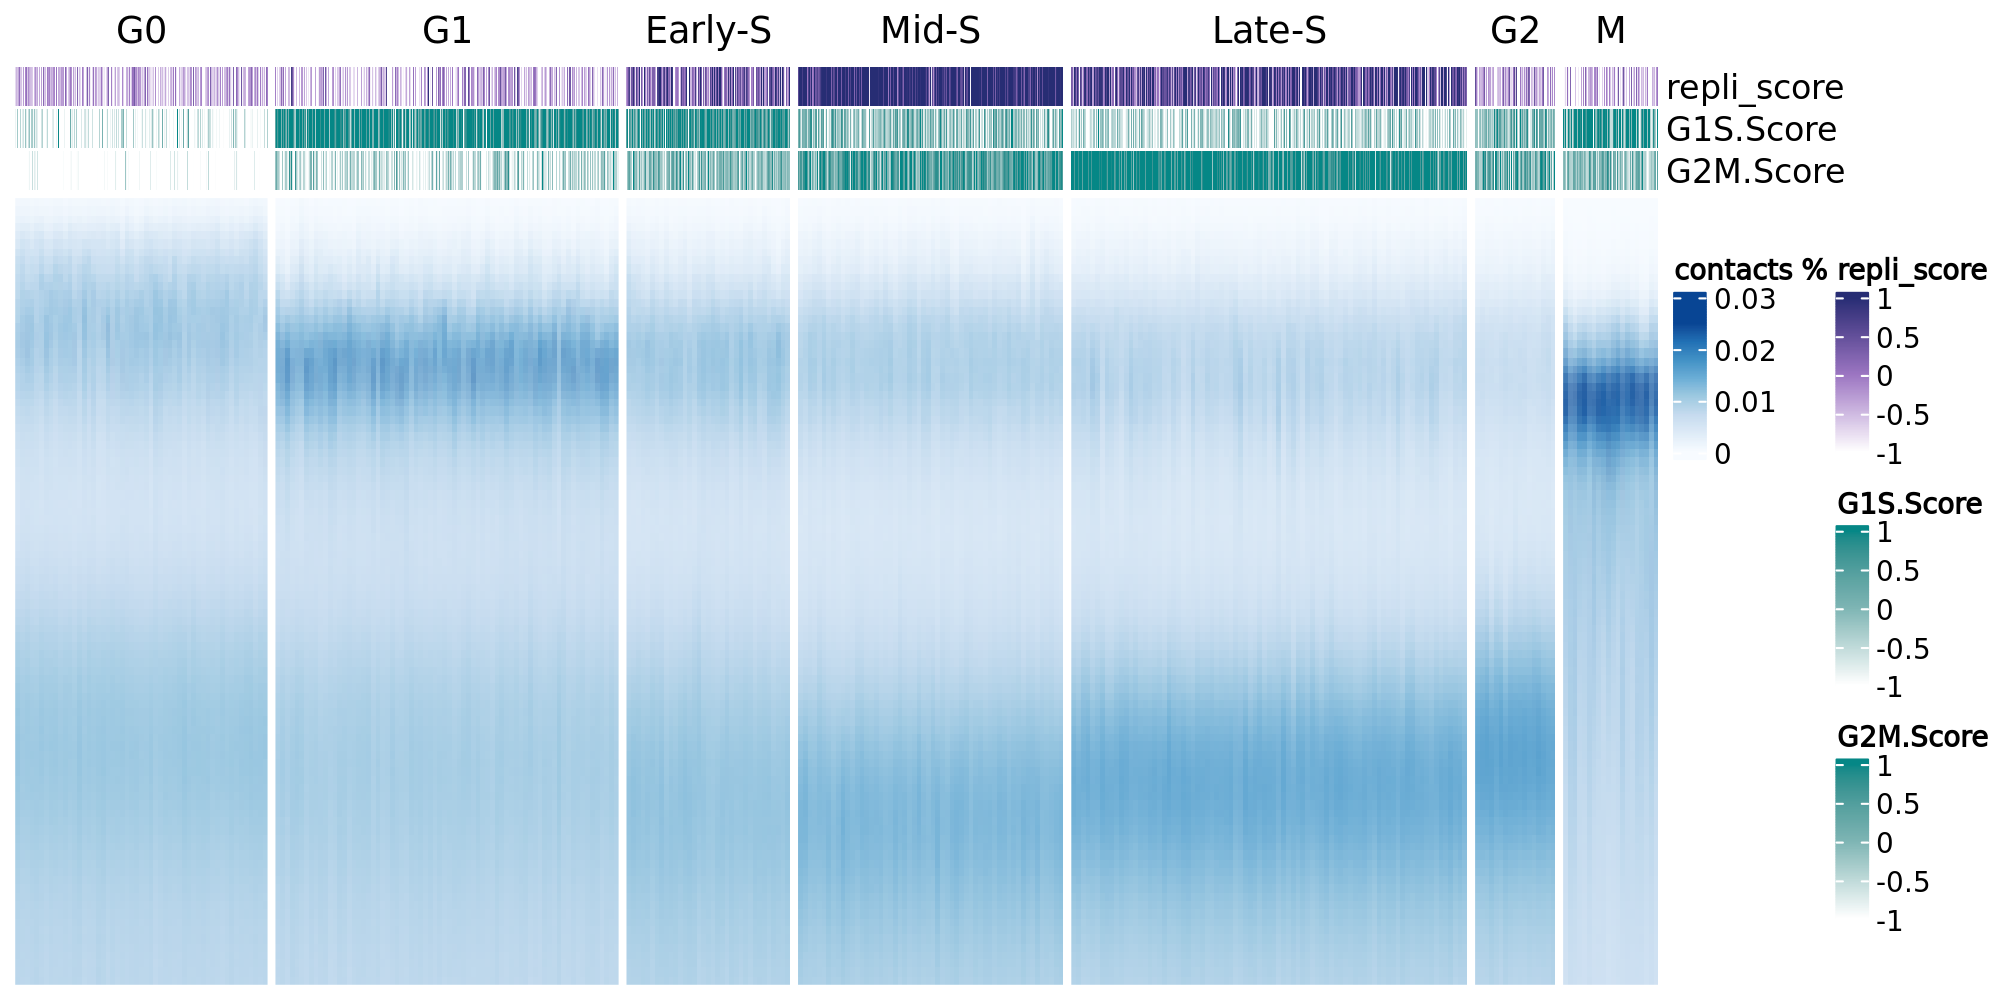

In [448]:
mat <- t(hires[["cdps"]]@data %>% as.matrix() )
set.seed(42)
colors <-c("#f7fbff","#deebf7","#c6dbef","#9ecae1","#6baed6","#4292c6","#2171b5","#084594")
tempOrderDF <- hires[[]] #%>% filter(celltype == "early mesoderm")
#order cells by cluster
tempOrderDF$cellcycle_threshold <- factor(tempOrderDF$cellcycle_threshold ,levels=c("G0","G1","Early-S","Mid-S","Late-S","G2","M"))
tempOrderDF <- tempOrderDF[sample(1:nrow(tempOrderDF)), ] #%>% arrange(desc(mitotic_p))
#addjust color scale

heatmap_mat <- mat[tempOrderDF  %>% pull(cellname),] %>% t() %>% as.data.frame

names(heatmap_mat) <- tempOrderDF %>%  pull(cellname)
heatmap_mat[heatmap_mat > 0.025] <- 0.025

library(circlize)
col_fun = colorRamp2(c(-1, 0, 1), c("#ffffff", "#9c76c2", "#272d74"))
col_fun1 = colorRamp2(c(-1, 0, 1), c("#ffffff","#7eb5b4","#058786"))

Annodf <- tempOrderDF %>% select(repli_score,G1S.Score,G2M.Score,sub_k_cluster,cluster,cellname,cellcycle_threshold)
Annodf <- Annodf %>% group_by(cellcycle_threshold)# %>% mutate(repli_score=mean(repli_score),G1S.Score=mean(G1S.Score),G2M.Score=mean(G2M.Score))
topAnno <- HeatmapAnnotation(df=Annodf %>% column_to_rownames("cellname")%>% select(repli_score,G1S.Score,G2M.Score) ,
                            col = list(repli_score = col_fun,G1S.Score = col_fun1,G2M.Score = col_fun1))

options(repr.plot.width=10,repr.plot.height=5,repr.plot.res=200)
p <- Heatmap(heatmap_mat%>% as.matrix(),cluster_rows = FALSE,cluster_columns = FALSE,col = colors,
       show_row_names = FALSE, show_column_names = FALSE,top_annotation= topAnno ,column_split= tempOrderDF %>% select(cellcycle_threshold),use_raster=TRUE,
        heatmap_legend_param = list(title = "contacts %")) #%>% suppressMessages()

svg(qq(paste0("plots/cdps_heatmap_all_withRNArepli.svg")), width = 12, height = 6)
draw(p)
dev.off()

draw(p)

In [449]:
mat <- hires[["cdps"]]@data %>% as.matrix() 
tempOrderDF <- hires[[]] #%>% filter(!cellcycle_threshold %in% c("G0"),celltype == celltype_i)
tempOrderDF <- tempOrderDF %>% mutate(clusterOrder = str_replace(paste0(str_replace(celltype," ","_"),"_",cluster,"_",sub_k_cluster),"_sub_",""))
tempOrderDF$cellcycle_threshold <- factor(tempOrderDF$cellcycle_threshold,levels = c("M","G0","G1","Early-S","Mid-S","Late-S","G2"))

tempOrderDF <- mat%>% as.data.frame %>% rownames_to_column("bin") %>%  gather(cellname,value,-bin) %>% group_by(cellname) %>% arrange(desc(value)) %>% slice(1) %>% ungroup() %>% 
    arrange(as.numeric(bin))%>% mutate(maxbinorder =row_number()) %>% select(cellname,maxbinorder) %>% right_join(tempOrderDF)

#same ordering as Tanay
tempOrderDF <- tempOrderDF %>% group_by(celltype) %>%  mutate(varrepli = var(raw_repli_score),varnearp = var(near_p),snearp=scale(near_p),sfar=scale(farAvg))

tempOrderDF <- tempOrderDF %>% group_by(celltype,cellcycle_threshold) %>% 
                 mutate(order = ifelse(cellcycle_threshold%in% c("Early-S"),near_p /varnearp + raw_repli_score / varrepli,
                                    ifelse(cellcycle_threshold %in% c("Mid-S","G2"), near_p /varnearp,
                                      ifelse(cellcycle_threshold %in% c("Late-S"),near_p / varnearp - raw_repli_score / varrepli,
                                            ifelse(cellcycle_threshold %in% c("G1","G0"),snearp + sfar,
                                                  ifelse(cellcycle_threshold %in% c("M","Unknown"),maxbinorder)))))) %>% arrange(celltype,cellcycle_threshold,order)
#order <- order %>% mutate(majorcellcycle = ifelse(cellcycle_threshold %in% c("G1","G0","Early-S"),1,cellcycle_threshold)) %>% arrange(cellcycle_threshold,order) %>% pull(cellname)

ordered_metadata <- rbind(tempOrderDF %>% filter(cellcycle_threshold != "G0") %>% ungroup() %>% group_by(celltype) %>% mutate(order = row_number()/n()),
                          tempOrderDF %>% filter(cellcycle_threshold == "G0") %>% mutate(order = row_number()/n())) %>% 
                         mutate(temp = cellname) %>% column_to_rownames("temp") %>% arrange(cellname)

Joining, by = c("cellname", "maxbinorder")


In [450]:
hires@meta.data <- ordered_metadata

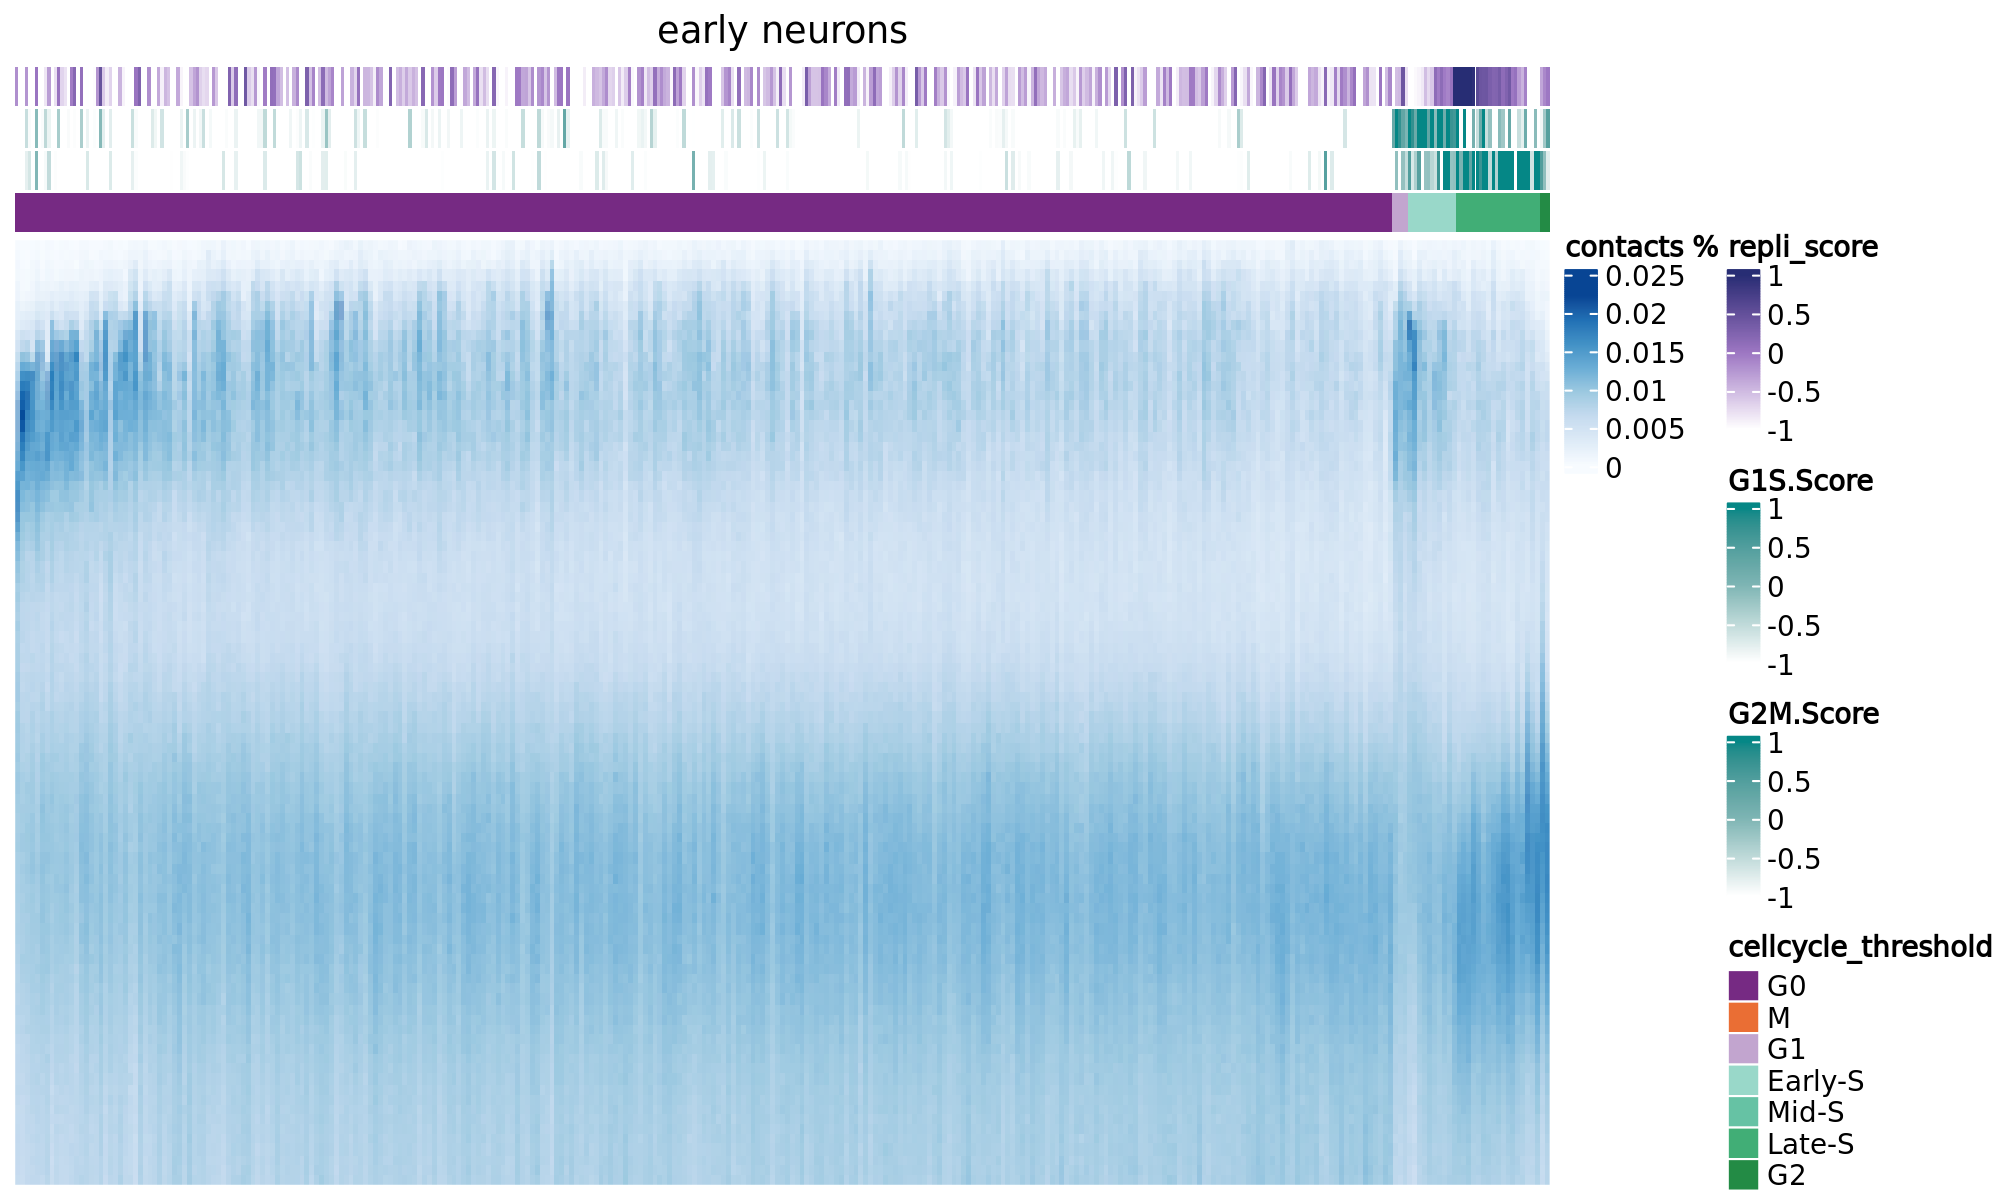

In [451]:
set.seed(42)
celltype_i <- "early neurons"

mat <- hires[["cdps"]]@data %>% as.matrix() 

tempOrderDF <- hires[[]] %>% filter(celltype == celltype_i)
#tempOrderDF <- tempOrderDF %>% mutate(clusterOrder = str_replace(paste0(str_replace(celltype," ","_"),"_",cluster,"_",sub_k_cluster),"_sub_",""))
tempOrderDF$cellcycle_threshold <- factor(tempOrderDF$cellcycle_threshold,levels = c("G0","M","G1","Early-S","Mid-S","Late-S","G2"))
order <- tempOrderDF %>% arrange(cellcycle_threshold,order) %>% pull(cellname)

tempOrderDF$cellname <- factor(tempOrderDF$cellname,levels = order)
tempOrderDF <- tempOrderDF %>% arrange(cellcycle_threshold,order)

heatmap_mat <- mat[,as.character(tempOrderDF$cellname)] %>% as.data.frame

names(heatmap_mat) <- tempOrderDF$cellname
heatmap_mat[heatmap_mat > 0.025] <- 0.025

library(circlize)
col_fun = colorRamp2(c(-1, 0, 1), c("#ffffff", "#9c76c2", "#272d74"))
col_fun1 = colorRamp2(c(-1, 0, 1), c("#ffffff","#7eb5b4","#058786"))

Annodf <- tempOrderDF %>% select(repli_score,G1S.Score,G2M.Score,sub_k_cluster,cluster,cellname,cellcycle_threshold)
Annodf <- Annodf %>% group_by(cellcycle_threshold) #%>% mutate(repli_score=mean(repli_score),G1S.Score=mean(G1S.Score),G2M.Score=mean(G2M.Score))
topAnno <- HeatmapAnnotation(df=Annodf %>% column_to_rownames("cellname")%>% select(repli_score,G1S.Score,G2M.Score,cellcycle_threshold) ,
                            col = list(repli_score = col_fun,G1S.Score = col_fun1,G2M.Score = col_fun1,cellcycle_threshold=cellcyclecolors),show_annotation_name=FALSE)

options(repr.plot.width=10,repr.plot.height=6,repr.plot.res=200)
p <- heatmap_mat%>% as.matrix() %>%
    Heatmap(cluster_rows = FALSE,cluster_columns = FALSE,show_row_names = FALSE, show_column_names = FALSE,colors,
       #    column_split= tempOrderDF %>% select(cellcycle_threshold,clusterOrder),
            use_raster=TRUE,top_annotation= topAnno,column_title=celltype_i,
            column_dend_reorder = TRUE,
               heatmap_legend_param = list(title = "contacts %"))
p

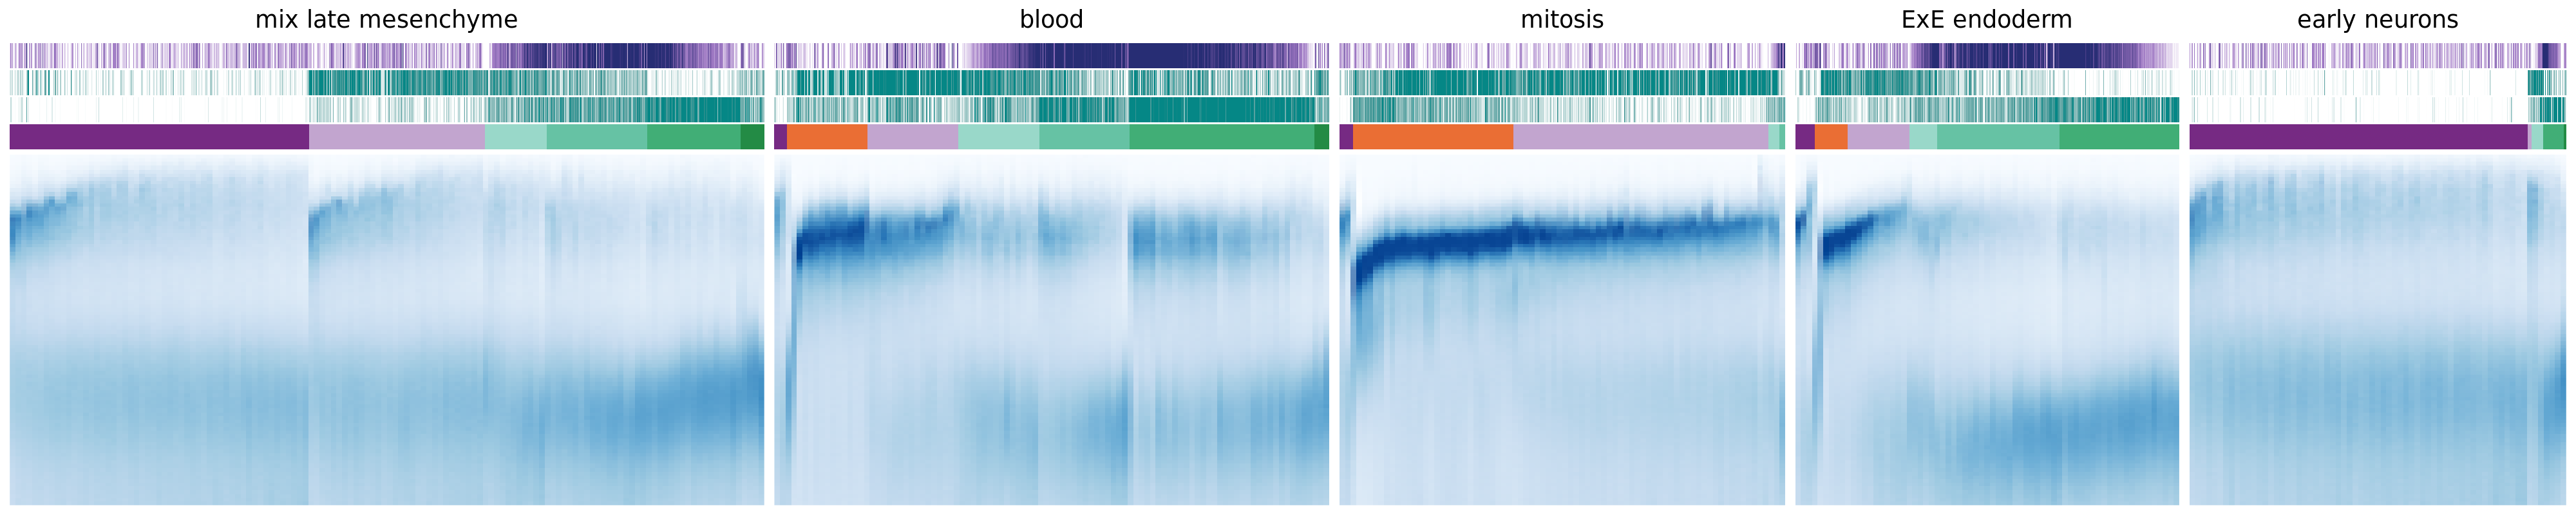

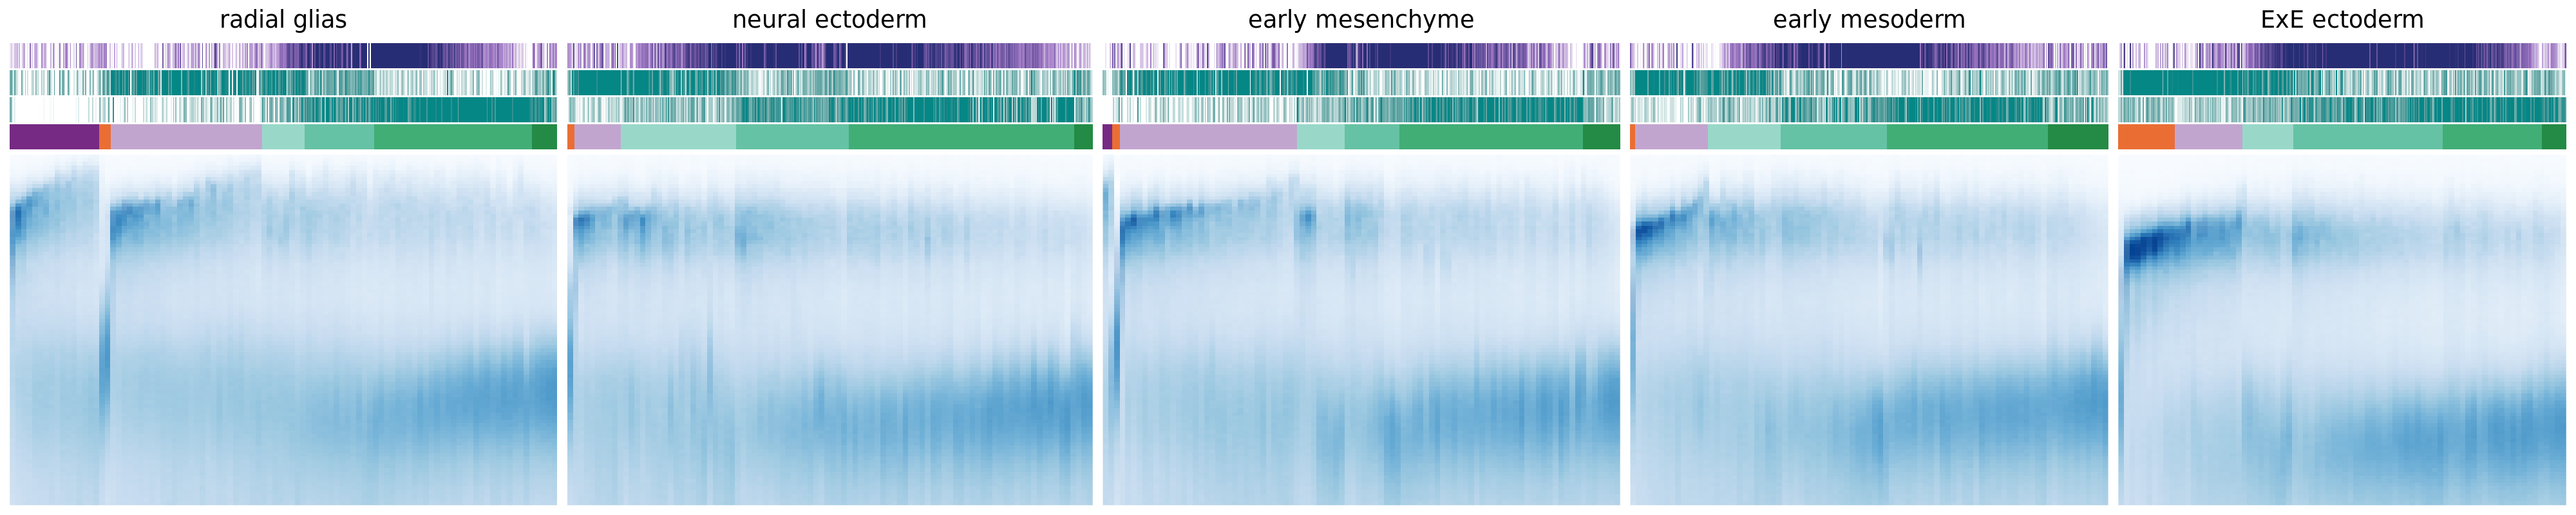

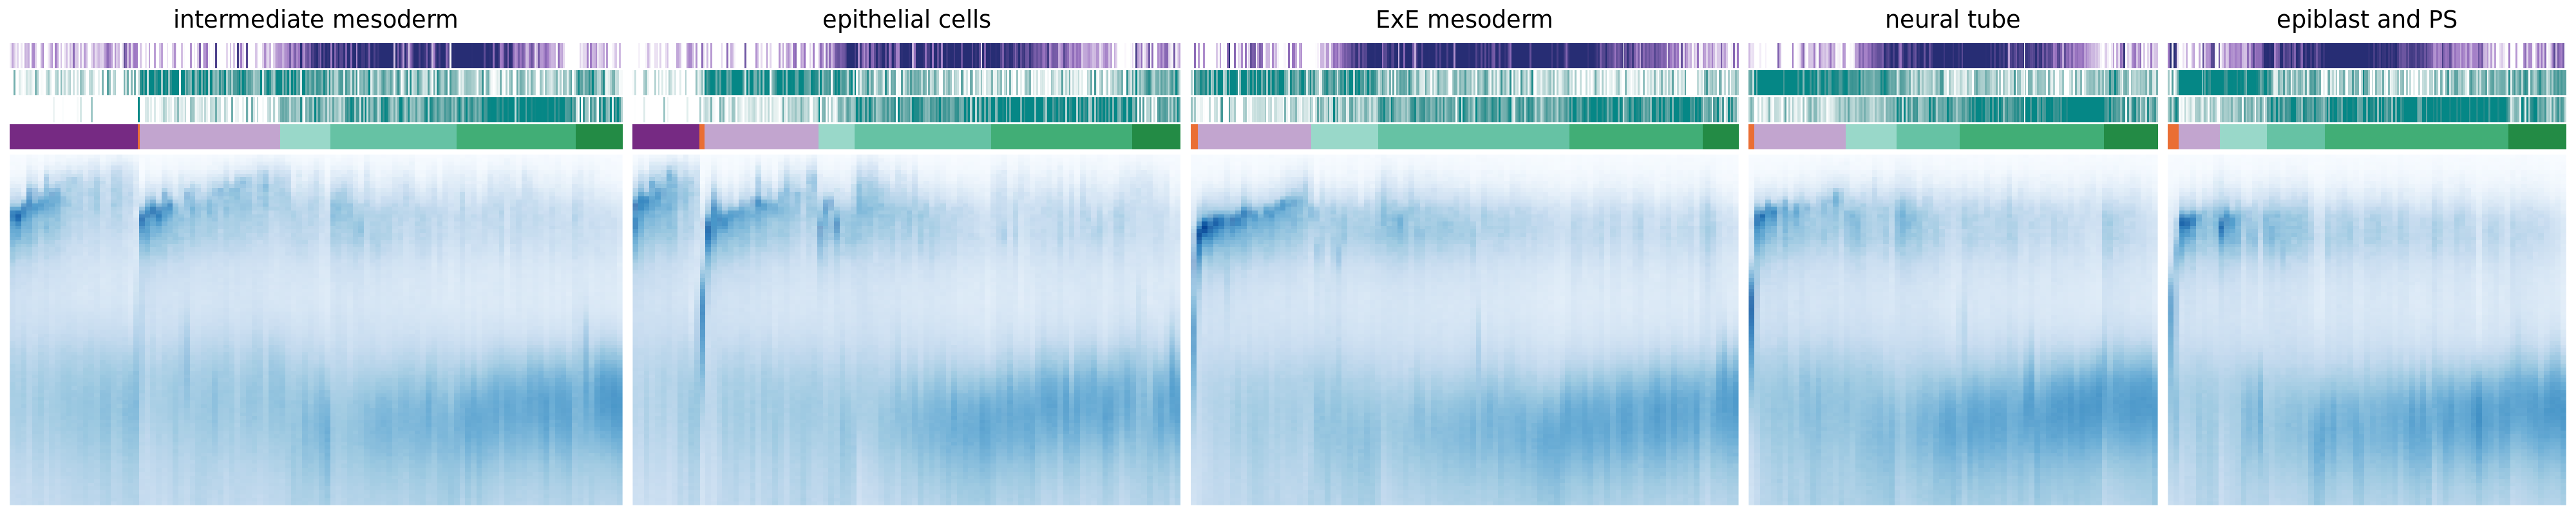

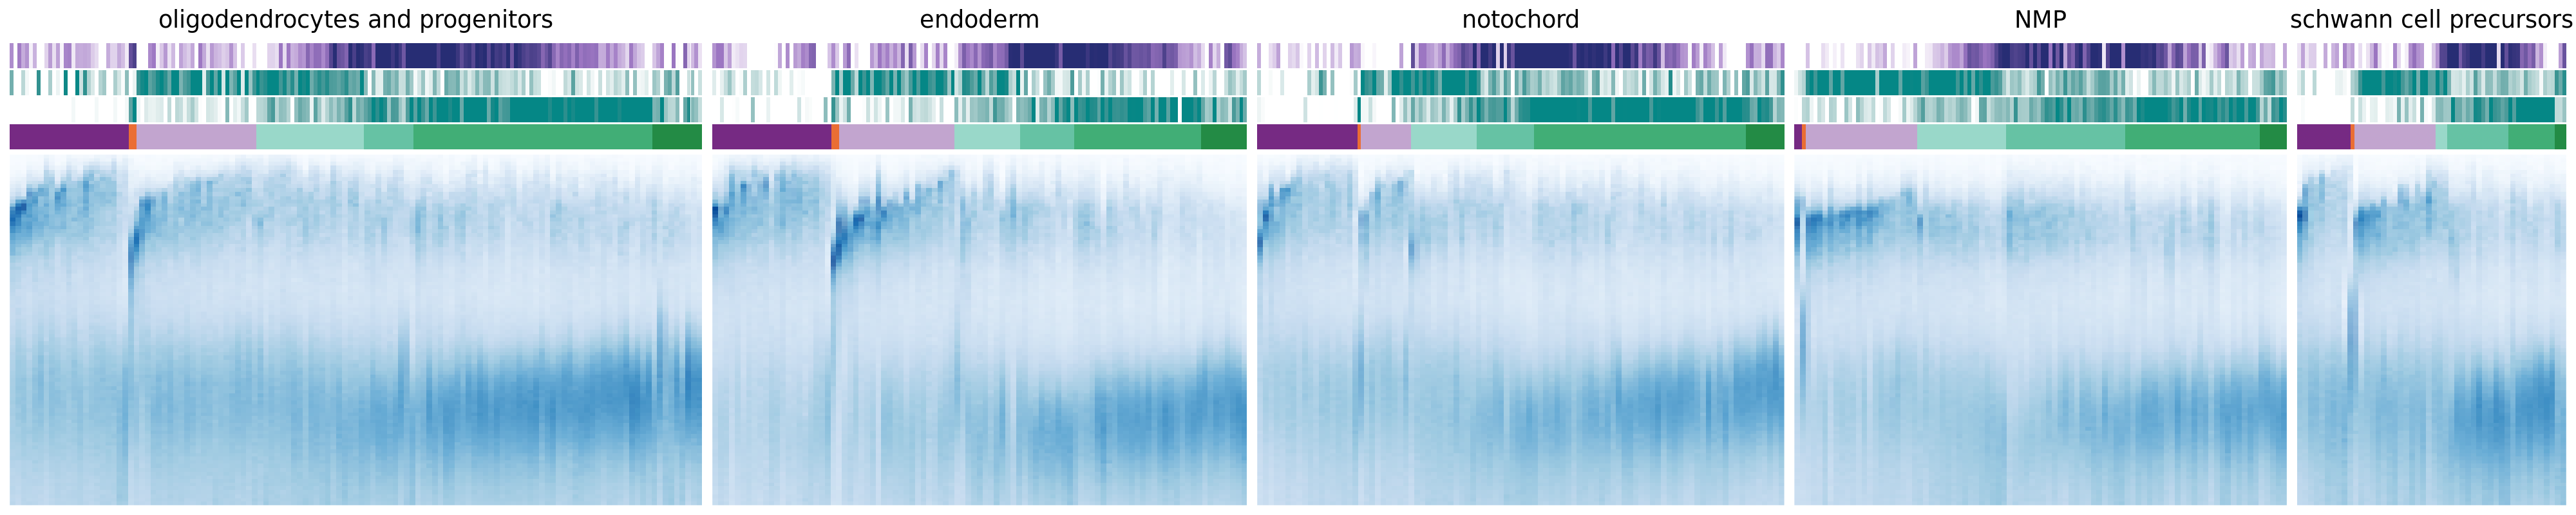

In [453]:
# ordering for all celltypes
plots <- list()
for (celltype_i in hires[[]] %>% group_by(celltype) %>% summarise(count = n()) %>% arrange(desc(count)) %>% pull(celltype)){
    set.seed(42)

    mat <- hires[["cdps"]]@data %>% as.matrix() 

    tempOrderDF <- hires[[]] %>% filter(celltype == celltype_i)
    #tempOrderDF <- tempOrderDF %>% mutate(clusterOrder = str_replace(paste0(str_replace(celltype," ","_"),"_",cluster,"_",sub_k_cluster),"_sub_",""))
    tempOrderDF$cellcycle_threshold <- factor(tempOrderDF$cellcycle_threshold,levels = c("G0","M","G1","Early-S","Mid-S","Late-S","G2"))
    order <- tempOrderDF %>% arrange(cellcycle_threshold,order) %>% pull(cellname)

    tempOrderDF$cellname <- factor(tempOrderDF$cellname,levels = order)
    tempOrderDF <- tempOrderDF %>% arrange(cellcycle_threshold,order)

    heatmap_mat <- mat[,as.character(tempOrderDF$cellname)] %>% as.data.frame

    names(heatmap_mat) <- tempOrderDF$cellname
    heatmap_mat[heatmap_mat > 0.025] <- 0.025

    library(circlize)
    col_fun = colorRamp2(c(-1, 0, 1), c("#ffffff", "#9c76c2", "#272d74"))
    col_fun1 = colorRamp2(c(-1, 0, 1), c("#ffffff","#7eb5b4","#058786"))

    Annodf <- tempOrderDF %>% select(repli_score,G1S.Score,G2M.Score,sub_k_cluster,cluster,cellname,cellcycle_threshold)
    Annodf <- Annodf %>% group_by(cellcycle_threshold) #%>% mutate(repli_score=mean(repli_score),G1S.Score=mean(G1S.Score),G2M.Score=mean(G2M.Score))
    topAnno <- HeatmapAnnotation(df=Annodf %>% column_to_rownames("cellname")%>% select(repli_score,G1S.Score,G2M.Score,cellcycle_threshold) ,
                                col = list(repli_score = col_fun,G1S.Score = col_fun1,G2M.Score = col_fun1,cellcycle_threshold=cellcyclecolors),show_annotation_name=FALSE)

    options(repr.plot.width=10,repr.plot.height=6,repr.plot.res=200)
    p <- heatmap_mat%>% as.matrix() %>%
        Heatmap(cluster_rows = FALSE,cluster_columns = FALSE,show_row_names = FALSE, show_column_names = FALSE,colors,
           #    column_split= tempOrderDF %>% select(cellcycle_threshold,clusterOrder),
                use_raster=TRUE,top_annotation= topAnno,column_title=celltype_i,
                column_dend_reorder = TRUE,
                   heatmap_legend_param = list(title = "contacts %"))
    if (length(plots)==0){
        plots <- p
    }else{
    plots <- plots + p
        }
}
#svg(qq(paste0("plots/order_earlymesoderm.svg")), width = 12, height = 6)
#draw(p,heatmap_legend_side = "right", annotation_legend_side = "left")
#dev.off()

#draw(plots,heatmap_legend_side = "right", annotation_legend_side = "left")
options(repr.plot.width=20,repr.plot.height=4,repr.plot.res=200)
draw(plots[,1:5], merge_legend = TRUE,show_heatmap_legend = FALSE)
draw(plots[,6:10], merge_legend = TRUE,show_heatmap_legend = FALSE)
draw(plots[,11:15], merge_legend = TRUE,show_heatmap_legend = FALSE)
draw(plots[,16:20],  merge_legend = TRUE,show_heatmap_legend = FALSE)

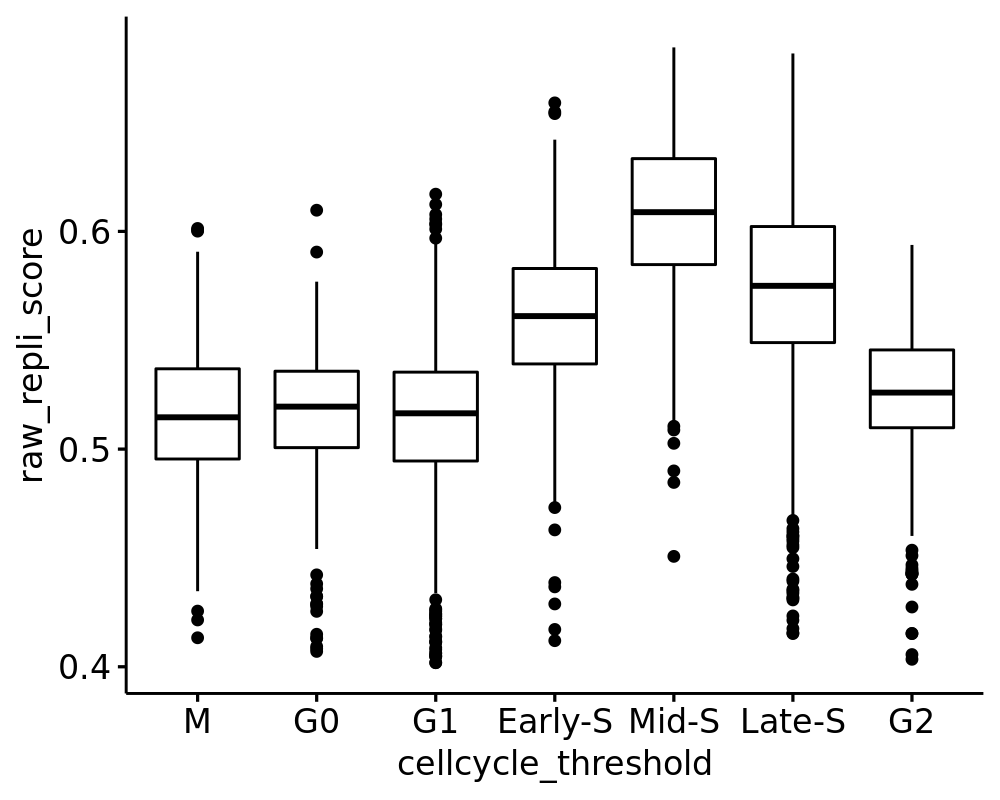

In [461]:
options(repr.plot.width=5,repr.plot.height=4,repr.plot.res=200)
hires@meta.data %>% filter(raw_repli_score > 0.4) %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="raw_repli_score")

In [466]:
hires@meta.data$cellcycle_threshold  <- factor(hires@meta.data$cellcycle_threshold ,levels=c("G0","M","G1","Early-S","Mid-S","Late-S","G2","Unknown"))

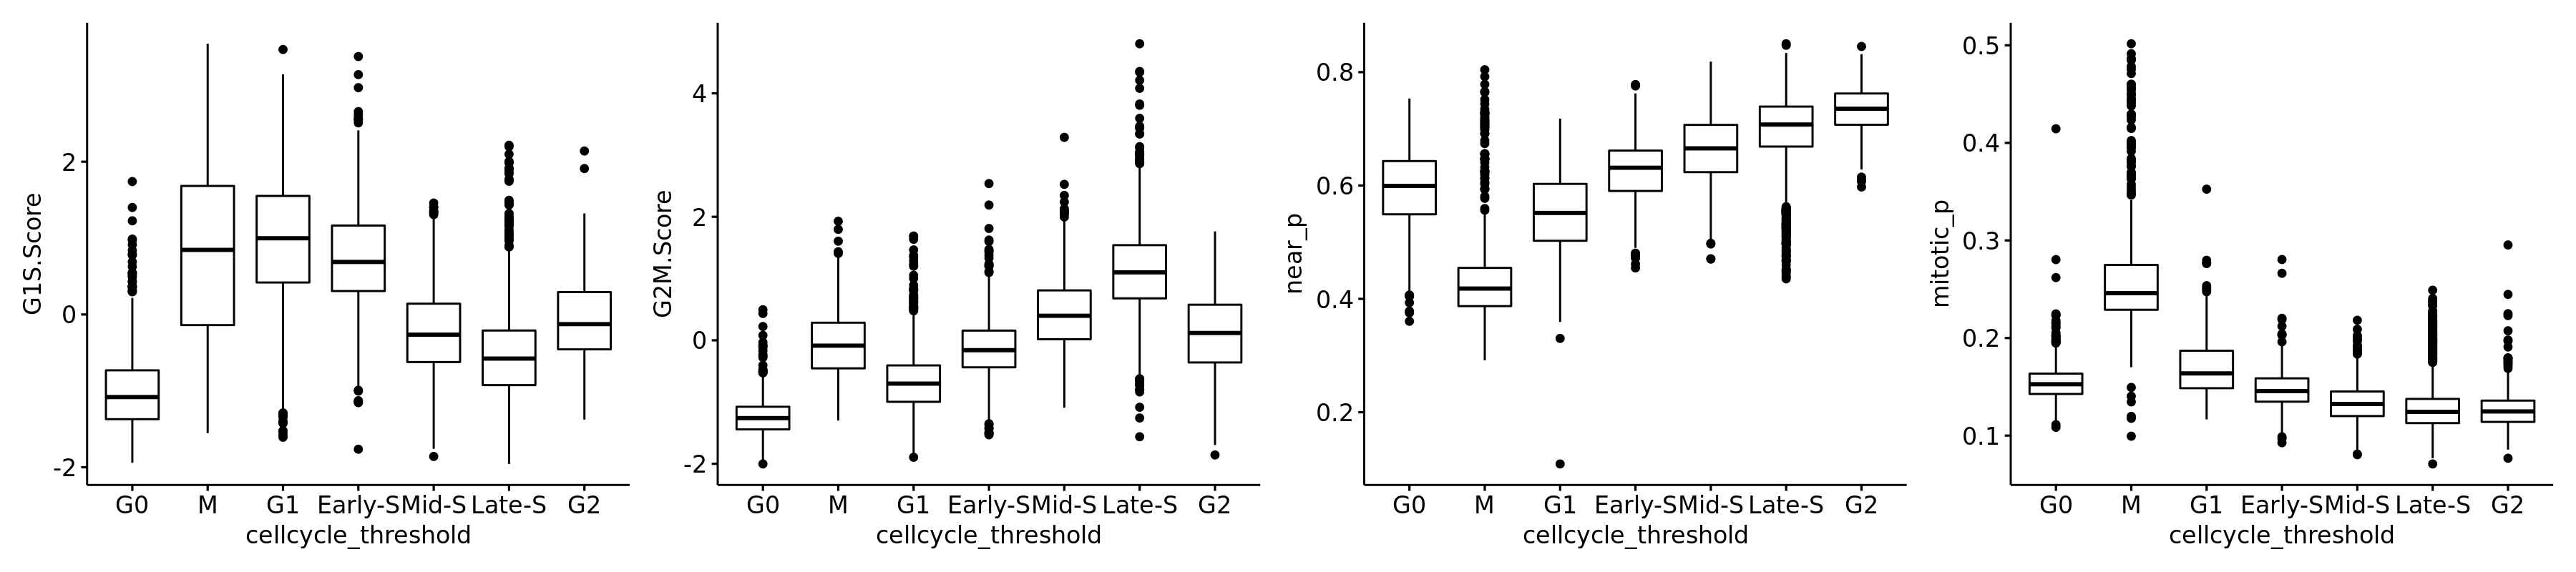

In [467]:
options(repr.plot.width=18,repr.plot.height=4,repr.plot.res=200)
a <- hires@meta.data %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="G1S.Score")
b <- hires@meta.data %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="G2M.Score")
c <- hires@meta.data %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="near_p")
d <- hires@meta.data %>% group_by(cellcycle_threshold) %>% ggboxplot(x="cellcycle_threshold",y="mitotic_p")
a | b| c| d

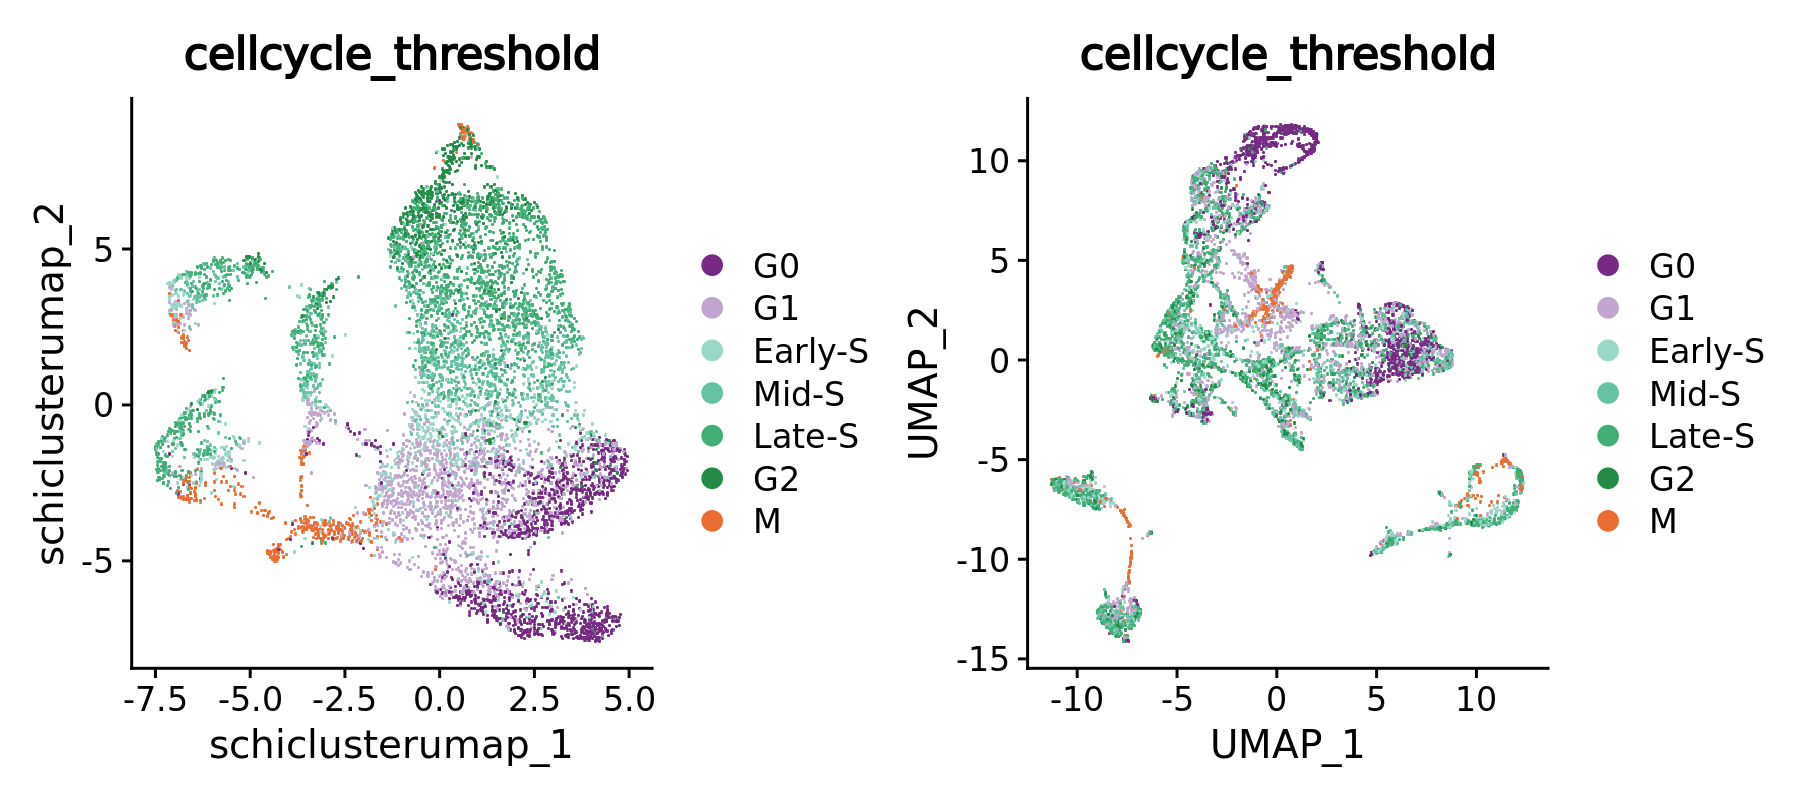

In [540]:
options(repr.plot.res=200,repr.plot.width=9,repr.plot.height=4)
a <- DimPlot(hires,dims = 1:2,group.by = "cellcycle_threshold",reduction = "schiclusterumap",raster = T,cols = cellcyclecolors[1:7])
b <- DimPlot(hires,dims = 1:2,group.by = "cellcycle_threshold",reduction = "umap",raster = T,cols = cellcyclecolors[1:7])
a|b